### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

os.chdir("/content/drive/MyDrive/Courses/CSCI566-DLA/Shashank/")

MessageError: ignored

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.datasets import SVHN
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import sys
import os
import time
import logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def overlay_y_on_x(x, y, num_labels):
    """Replace the first num_label pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :num_labels] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

In [5]:
!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch.nn.functional as F

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim, device=device),
            nn.Linear(patch_dim, dim, device=device)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00


In [6]:
class Attention_layer(nn.Module):

  def __init__(self, input_size: tuple, output_size: int, patch_size: int, dim: int):
    """
      input_size: n_h, n_w, n_c
      output_size: int
      patch_size: int
    """
    super().__init__()
    self.input_size = input_size
    self.patch_size = patch_size
    self.output_size = output_size

    n_h, n_w, n_c = input_size
    patch_dim = n_h // patch_size
    num_patches = patch_dim ** 2 
    # self.patch_embedding = nn.Conv2d(n_c, 64, kernel_size=patch_size, stride=patch_size, device=device)
    self.patch_embedding = SPT(dim=dim, patch_size=patch_size, channels=n_c)

    # for param in self.patch_embedding.parameters():
    #   param.requires_grad = False

    self.self_attn = nn.MultiheadAttention(dim, 2, device=device)
    self.fc1 = nn.Linear(dim, output_size, device=device)
    self.lrelu = nn.ReLU() #nn.LeakyReLU()

  def __normalize(self, x):
    x_shape = x.shape
    x = x.reshape(x_shape[0], -1)
    x = x / (x.norm(2, 1, keepdim=True) + 1e-4)
    x = x.reshape(x_shape)
    return x

  def __reshape(self, x):
    x = x.reshape(x.size(0), self.input_size[2], self.input_size[0], self.input_size[1])
    return x

  def forward(self, x):
    x = self.__normalize(x) 
    x = self.__reshape(x) # (batch_size, channel_size, height, width)
    x = self.patch_embedding(x) # (batch_size, num_patches, dim)
    # x = x.flatten(2).transpose(1, 2) # (batch_size, num_patches, 64)

    x = x.transpose(0, 1)  # (num_patches, batch_size, dim)
    x, _ = self.self_attn(x, x, x)
    x = x.mean(dim=0) # (batch_size, dim)


    x = self.__normalize(x)
    x = self.fc1(x)

    x = self.lrelu(x)

    return x
  
  def train_ff(self, train_loader, epoch_range, batch_size, lr=0.03, threshold=2.0):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    next_pos = []
    next_neg = []
    next_label = []
    for e in epoch_range:
      # x_pos = x_pos.to(device)
      # x_neg = x_neg.to(device)
      # for e in epoch_range:
      for (x_pos, x_neg, label) in train_loader:
        x_pos = x_pos.to(device)
        x_neg = x_neg.to(device)
        g_pos = self.forward(x_pos).pow(2).mean(dim=1)
        g_neg = self.forward(x_neg).pow(2).mean(dim=1)

        loss = torch.log(1 + torch.exp(
            torch.cat([
                threshold - g_pos,
                g_neg - threshold
            ])
        )).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        x_pos = x_pos.detach()
        x_neg = x_neg.detach()

    for (x_pos, x_neg, label) in train_loader:
      x_pos = x_pos.to(device)
      x_neg = x_neg.to(device)    
      x_pos_next = self.forward(x_pos).detach()
      x_neg_next = self.forward(x_neg).detach()
      next_pos.append(x_pos_next)
      next_neg.append(x_neg_next)
      next_label.append(label)
      x_pos = x_pos.detach()
      x_neg = x_neg.detach()
    
    next_pos = torch.cat(next_pos, dim=0)
    next_neg = torch.cat(next_neg, dim=0)
    next_label = torch.cat(next_label, dim=0)

    return DataLoader(TensorDataset(
        next_pos,
        next_neg,
        next_label
    ), batch_size=batch_size, shuffle=True)
    


In [7]:
class Linear_layer(nn.Linear):

  def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
    super().__init__(in_features, out_features, bias, device, dtype)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
      x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
      return self.relu(
          torch.mm(x_direction, self.weight.T) +
          self.bias.unsqueeze(0))

  def train_ff(self, train_loader, epoch_range, batch_size, lr=0.03, threshold=2.0):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    next_pos = []
    next_neg = []
    next_label = []
    # for (x_pos, x_neg, label) in train_loader:
    #   x_pos = x_pos.to(device)
    #   x_neg = x_neg.to(device)
      # for i in epoch_range:
    for i in epoch_range:
      
      for (x_pos, x_neg, label) in train_loader:
        x_pos = x_pos.to(device)
        x_neg = x_neg.to(device)
        g_pos = self.forward(x_pos).pow(2).mean(1)
        g_neg = self.forward(x_neg).pow(2).mean(1)
          
        loss = torch.log(1 + torch.exp(torch.cat([
            -g_pos + threshold,
            g_neg - threshold]))).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        x_pos = x_pos.detach()
        x_neg = x_neg.detach()
    
    for (x_pos, x_neg, label) in train_loader:
      x_pos = x_pos.to(device)
      x_neg = x_neg.to(device)  
      x_pos_next = self.forward(x_pos).detach()
      x_neg_next = self.forward(x_neg).detach()
      next_pos.append(x_pos_next)
      next_neg.append(x_neg_next)
      next_label.append(label)
      x_pos = x_pos.detach()
      x_neg = x_neg.detach()
  
    next_pos = torch.cat(next_pos, dim=0)
    next_neg = torch.cat(next_neg, dim=0)
    next_label = torch.cat(next_label, dim=0)
    
    return DataLoader(TensorDataset(
        next_pos,
        next_neg,
        next_label
    ), batch_size=batch_size, shuffle=True)

In [8]:
class Net(nn.Module):

  def __init__(self, layers, num_labels):
    super().__init__()
    self.layers = layers
    self.num_labels = num_labels

  def train_ff(self, train_loader, epochs=1000, **kwargs):
    cur_train_loader = train_loader
    batch_size = train_loader.batch_size
    for i, layer in enumerate(self.layers):
      
      is_large_batch = len(cur_train_loader) >= 5
      print(f"Training layer: {i+1} ... tqdm: {'loader' if not is_large_batch else 'epoch'}")

      cur_train_loader = tqdm(cur_train_loader) if not is_large_batch else cur_train_loader
      epoch_range = tqdm(range(epochs)) if is_large_batch else range(epochs)
      cur_train_loader = layer.train_ff(cur_train_loader, epoch_range=epoch_range, batch_size=batch_size, **kwargs)
      
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def predict_ff(self, data_loader):

    def predict(layers, x, num_labels):
      goodness_per_label = []
      for label in range(num_labels):
          h = overlay_y_on_x(x, label, num_labels)
          goodness = []
          for i, layer in enumerate(layers):
              h = layer(h)
              # if i==0:
                # continue
              goodness += [h.pow(2).mean(1)]
          goodness_per_label += [sum(goodness).unsqueeze(1)]
      goodness_per_label = torch.cat(goodness_per_label, 1)
      return goodness_per_label.argmax(1)
    
    preds = []
    labels = []
    for x, label in data_loader:
      x = x.to(device)
      preds.append(predict(self.layers, x, self.num_labels))
      labels.append(label)

    preds = torch.cat(preds, 0)
    labels = torch.cat(labels, 0)
    return preds.cpu(), labels.cpu()

  def predict_bp(self, data_loader):
    preds = []
    labels = []
    for input, label in data_loader:
      input = input.to(device)
      pred = self.forward(input)
      preds.append(pred.argmax(1))
      labels.append(label)
    preds = torch.cat(preds, 0)
    labels = torch.cat(labels,0)
    return preds.cpu(), labels.cpu()

In [23]:
! rm -rf ./data

In [20]:
def MNIST_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = MNIST('./data', train=True,
              download=True,
              transform=transform)
  test_data = MNIST('./data', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

train_data, test_data = MNIST_dataset()
print(train_data, test_data)

100%|██████████| 9912422/9912422 [00:00<00:00, 83089105.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106166252.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26607359.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7769383.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [24]:
def FashionMNIST_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = FashionMNIST('./data', train=True,
              download=True,
              transform=transform)
  test_data = FashionMNIST('./data', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

train_data, test_data = FashionMNIST_dataset()
print(train_data, test_data)

100%|██████████| 26421880/26421880 [00:01<00:00, 16204431.93it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271484.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5084679.63it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4750776.02it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [34]:
def CIFAR10_dataset():

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.4914, 0.4822, 0.4465)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = CIFAR10('./data', train=True,
              download=True,
              transform=transform)

    test_loader = CIFAR10('./data', train=False,
              download=True,
              transform=transform)

    return train_loader, test_loader

In [35]:
def CIFAR100_dataset():

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = CIFAR100('./data', train=True,
              download=True,
              transform=transform)

    test_loader = CIFAR100('./data', train=False,
              download=True,
              transform=transform)

    return train_loader, test_loader

In [36]:
def SVHN_dataset():

    transform = Compose([
        ToTensor(),
        Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = SVHN('./data', split='train',
              download=True,
              transform=transform)

    test_loader = SVHN('./data', split='test',
              download=True,
              transform=transform)

    return train_loader, test_loader

In [25]:
def create_ff_train_dataset(train_loader, num_labels):
  pos_set = []
  neg_set = []
  label_set = []
  for input, label in tqdm(train_loader):
    x_pos = overlay_y_on_x(input, label, num_labels)
    rnd = torch.randperm(input.size(0))
    x_neg = overlay_y_on_x(input, label[rnd], num_labels)
    pos_set.append(x_pos)
    neg_set.append(x_neg)
    label_set.append(label)
  pos_set = torch.cat(pos_set, 0)
  neg_set = torch.cat(neg_set, 0)
  label_set = torch.cat(label_set, 0)
  return TensorDataset(pos_set, neg_set, label_set)

def create_ff_val_dataset(val_loader):
  inputs = []
  labels = []

  for input, label in tqdm(val_loader):
    inputs.append(input)
    labels.append(label)
  inputs = torch.cat(inputs, 0)
  labels = torch.cat(labels, 0)
  return TensorDataset(inputs, labels)

In [65]:
train_data, test_data = CIFAR100_dataset()
print(train_data, test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
               Lambda()
           ) Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
               Lambda()
           )


In [90]:
train_dataset = create_ff_train_dataset(DataLoader(train_data, batch_size=1024, shuffle=False), 100)

100%|██████████| 49/49 [00:17<00:00,  2.88it/s]


In [91]:
test_dataset = create_ff_val_dataset(DataLoader(test_data, batch_size=1024, shuffle=False))

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


In [98]:
layers = [
    # Linear_layer(28*28, 2000, device=device),
    Linear_layer(32*32*3, 2000, device=device),
    Linear_layer(2000, 2000, device=device),
    Linear_layer(2000, 2000, device=device),
    Linear_layer(2000, 2000, device=device)
]
net = Net(layers, 100)

In [99]:
net.train_ff(DataLoader(train_dataset, batch_size=512, shuffle=True), epochs=60, lr=0.02, threshold=25)

Training layer: 1 ... tqdm: epoch


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


Training layer: 2 ... tqdm: epoch


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


Training layer: 3 ... tqdm: epoch


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


Training layer: 4 ... tqdm: epoch


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


In [94]:
pred, true = net.predict_ff(DataLoader(train_data, batch_size=512, shuffle=False))
accuracy_score(true, pred)

0.1092

In [100]:
pred, true = net.predict_ff(DataLoader(test_dataset, batch_size=512, shuffle=False))
accuracy_score(true, pred)

0.0833

In [96]:
f1_score(true, pred, average=None)

array([0.19047619, 0.11692308, 0.07058824, 0.        , 0.08658009,
       0.03603604, 0.        , 0.06389776, 0.        , 0.01980198,
       0.        , 0.        , 0.        , 0.01960784, 0.03007519,
       0.        , 0.        , 0.13461538, 0.12624585, 0.        ,
       0.11264822, 0.18061674, 0.        , 0.20298507, 0.17631579,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.20394737, 0.02247191, 0.        , 0.0969163 , 0.        ,
       0.03448276, 0.12048193, 0.0483871 , 0.01680672, 0.        ,
       0.        , 0.        , 0.02919708, 0.01869159, 0.        ,
       0.        , 0.        , 0.17813765, 0.05194805, 0.10285714,
       0.        , 0.10759494, 0.18313253, 0.27989822, 0.06153846,
       0.        , 0.08888889, 0.        , 0.05405405, 0.        ,
       0.30463576, 0.10493827, 0.14010508, 0.09230769, 0.        ,
       0.        , 0.0361991 , 0.03669725, 0.2835249 , 0.        ,
       0.23584906, 0.25092251, 0.        , 0.01980198, 0.06896

In [ ]:
layers = [
    Attention_layer((28, 28, 1), 2000, 4, 256),
    Linear_layer(2000, 2000, device=device),
    Linear_layer(2000, 2000, device=device),
    Linear_layer(2000, 2000, device=device)
]
net = Net(layers, 10)

In [ ]:
net.train_ff(DataLoader(train_dataset, batch_size=512, shuffle=False), epochs=60, lr=0.02, threshold=15)

Training layer: 1 ... tqdm: epoch


100%|██████████| 60/60 [06:00<00:00,  6.02s/it]


Training layer: 2 ... tqdm: epoch


100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


Training layer: 3 ... tqdm: epoch


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


Training layer: 4 ... tqdm: epoch


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


In [ ]:
pred, true = net.predict_ff(DataLoader(test_dataset, batch_size=512, shuffle=False))

In [ ]:
accuracy_score(true, pred)

0.5965

In [ ]:
f1_score(true, pred, average=None)

array([0.63659662, 0.91692308, 0.45727221, 0.57894737, 0.61571863,
       0.33673469, 0.63985594, 0.65384615, 0.57237569, 0.47451963])

## Ignore

In [ ]:
class Net:

  def __init__(self, seq_length, input_size, num_labels):
    self.self_attn1 = nn.MultiheadAttention(embed_dim=seq_length, num_heads=8, )
    prev = input_size
    self.layers = []
    for l in hidden_dims:
      self.layers.append(nn.Linear(prev, l, device=device))
      prev = l
    self.layers.append(nn.Linear(prev, output_size, device=device))
    self.relu = nn.ReLU()
    self.num_labels = num_labels

  def forward_ff(self, layer, data):
    data = data / (data.norm(2, 1, keepdim=True) + 1e-4)
    return self.relu(layer.forward(data))

  def forward_bp(self, data):
    out = data
    for layer in self.layers[:-1]:
      out = layer(out)
      out = self.relu(out)
    last_layer = self.layers[-1]
    out = last_layer(out)
    return out

  def get_next_dataset_ff(self, layer, dataset, batch_size):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    x_pos_set = []
    x_neg_set = []
    for (x_pos, x_neg) in data_loader:
      x_pos = x_pos.to(device)
      x_neg = x_neg.to(device)
      x_pos_set.append(self.forward_ff(layer, x_pos).detach())
      x_neg_set.append(self.forward_ff(layer, x_neg).detach())
    x_pos_set = torch.cat(x_pos_set, dim=0)
    x_neg_set = torch.cat(x_neg_set, dim=0)
    return TensorDataset(
        x_pos_set,
        x_neg_set
    )

  def predict_bp(self, data_loader):
    preds = []
    labels = []
    for input, label in data_loader:
      input = input.to(device)
      pred = self.forward_bp(input)
      preds.append(pred.argmax(1))
      labels.append(label)
    preds = torch.cat(preds, 0)
    labels = torch.cat(labels,0)
    return preds.cpu(), labels.cpu()


  def predict_ff(self, data_loader):

    def predict(layers, x, num_labels):
      goodness_per_label = []
      for label in range(num_labels):
          h = overlay_y_on_x(x, label, num_labels)
          goodness = []
          for layer in layers:
              h = self.forward_ff(layer, h)
              goodness += [h.pow(2).mean(1)]
          goodness_per_label += [sum(goodness).unsqueeze(1)]
      goodness_per_label = torch.cat(goodness_per_label, 1)
      return goodness_per_label.argmax(1)
    
    preds = []
    labels = []
    for x, label in data_loader:
      x = x.to(device)
      preds.append(predict(self.layers, x, self.num_labels))
      labels.append(label)

    preds = torch.cat(preds, 0)
    labels = torch.cat(labels, 0)
    return preds.cpu(), labels.cpu()

  def train_bp(self, optimizer, loss_fn, train_loader, val_loader, epochs=1000, learning_rate=0.001):
    params = []
    for layer in self.layers:
        params += list(layer.parameters())
    optimizer = optimizer(params, lr=learning_rate)

    for e in range(epochs):
      print(f"Epoch: {e + 1}/ {epochs}")
      print("-" * 100)
      total_loss = 0
      for input, label in tqdm(train_loader):
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = self.forward_bp(input)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
      print(f"Train loss: {total_loss / len(train_loader)}")
    
    pred, actual = self.predict_bp(val_loader)
    print(f"Val accuracy: {accuracy_score(actual, pred)}")
    print(f"Val F1 score: {f1_score(actual, pred, average=None)}")

  def train_ff(self, optimizer, train_set, val_set, epochs=1000, learning_rate=0.001, threshold=2, batch_size=1024, val_batch_size=10000):
    cur_train_set = train_set
    
    for layer_num, layer in enumerate(self.layers):
      print(f"Training layer: {layer_num}")
      cur_train_loader = DataLoader(cur_train_set, batch_size=batch_size, shuffle=True)
      opt = optimizer(layer.parameters(), lr=learning_rate)

      is_large_batch = len(cur_train_loader) <= 5

      cur_train_loader = tqdm(cur_train_loader) if not is_large_batch else cur_train_loader
      epoch_range = tqdm(range(epochs)) if is_large_batch else range(epochs)

      for (x_pos, x_neg) in cur_train_loader:
        x_pos = x_pos.to(device)
        x_neg = x_neg.to(device)
        for e in epoch_range:
          
          x_pos_out = self.forward_ff(layer, x_pos)
          x_neg_out = self.forward_ff(layer, x_neg)

          g_pos = x_pos_out.pow(2).mean(1)
          g_neg = x_neg_out.pow(2).mean(1)

          opt.zero_grad()
          loss = torch.log(1 + torch.exp(torch.cat([
                  -g_pos + threshold,
                  g_neg - threshold]))).mean()
          loss.backward()
          opt.step()
      cur_train_set = self.get_next_dataset_ff(layer, cur_train_set, batch_size)
  
    pred, actual = self.predict_ff(DataLoader(val_set, batch_size=val_batch_size, shuffle=False))
    print(f"Val accuracy: {accuracy_score(actual, pred)}")
    print(f"Val F1 score: {f1_score(actual, pred, average=None)}")




  


In [ ]:
class Net:

  def __init__(self, input_size, hidden_dims, output_size, num_labels):
    prev = input_size
    self.layers = []
    for l in hidden_dims:
      self.layers.append(nn.Linear(prev, l, device=device))
      prev = l
    self.layers.append(nn.Linear(prev, output_size, device=device))
    self.relu = nn.ReLU()
    self.num_labels = num_labels

  def forward_ff(self, layer, data):
    data = data / (data.norm(2, 1, keepdim=True) + 1e-4)
    return self.relu(layer.forward(data))

  def forward_bp(self, data):
    out = data
    for layer in self.layers[:-1]:
      out = layer(out)
      out = self.relu(out)
    last_layer = self.layers[-1]
    out = last_layer(out)
    return out

  def get_next_dataset_ff(self, layer, dataset, batch_size):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    x_pos_set = []
    x_neg_set = []
    for (x_pos, x_neg) in data_loader:
      x_pos = x_pos.to(device)
      x_neg = x_neg.to(device)
      x_pos_set.append(self.forward_ff(layer, x_pos).detach())
      x_neg_set.append(self.forward_ff(layer, x_neg).detach())
    x_pos_set = torch.cat(x_pos_set, dim=0)
    x_neg_set = torch.cat(x_neg_set, dim=0)
    return TensorDataset(
        x_pos_set,
        x_neg_set
    )

  def predict_bp(self, data_loader):
    preds = []
    labels = []
    for input, label in data_loader:
      input = input.to(device)
      pred = self.forward_bp(input)
      preds.append(pred.argmax(1))
      labels.append(label)
    preds = torch.cat(preds, 0)
    labels = torch.cat(labels,0)
    return preds.cpu(), labels.cpu()


  def predict_ff(self, data_loader):

    def predict(layers, x, num_labels):
      goodness_per_label = []
      for label in range(num_labels):
          h = overlay_y_on_x(x, label, num_labels)
          goodness = []
          for layer in layers:
              h = self.forward_ff(layer, h)
              goodness += [h.pow(2).mean(1)]
          goodness_per_label += [sum(goodness).unsqueeze(1)]
      goodness_per_label = torch.cat(goodness_per_label, 1)
      return goodness_per_label.argmax(1)
    
    preds = []
    labels = []
    for x, label in data_loader:
      x = x.to(device)
      preds.append(predict(self.layers, x, self.num_labels))
      labels.append(label)

    preds = torch.cat(preds, 0)
    labels = torch.cat(labels, 0)
    return preds.cpu(), labels.cpu()

  def train_bp(self, optimizer, loss_fn, train_loader, val_loader, epochs=1000, learning_rate=0.001):
    params = []
    for layer in self.layers:
        params += list(layer.parameters())
    optimizer = optimizer(params, lr=learning_rate)

    for e in range(epochs):
      print(f"Epoch: {e + 1}/ {epochs}")
      print("-" * 100)
      total_loss = 0
      for input, label in tqdm(train_loader):
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = self.forward_bp(input)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
      print(f"Train loss: {total_loss / len(train_loader)}")
    
    pred, actual = self.predict_bp(val_loader)
    print(f"Val accuracy: {accuracy_score(actual, pred)}")
    print(f"Val F1 score: {f1_score(actual, pred, average=None)}")

  def train_ff(self, optimizer, train_set, val_set, epochs=1000, learning_rate=0.001, threshold=2, batch_size=1024, val_batch_size=10000):
    cur_train_set = train_set
    
    for layer_num, layer in enumerate(self.layers):
      print(f"Training layer: {layer_num}")
      cur_train_loader = DataLoader(cur_train_set, batch_size=batch_size, shuffle=True)
      opt = optimizer(layer.parameters(), lr=learning_rate)

      is_large_batch = len(cur_train_loader) <= 5

      cur_train_loader = tqdm(cur_train_loader) if not is_large_batch else cur_train_loader
      epoch_range = tqdm(range(epochs)) if is_large_batch else range(epochs)

      for (x_pos, x_neg) in cur_train_loader:
        x_pos = x_pos.to(device)
        x_neg = x_neg.to(device)
        for e in epoch_range:
          
          x_pos_out = self.forward_ff(layer, x_pos)
          x_neg_out = self.forward_ff(layer, x_neg)

          g_pos = x_pos_out.pow(2).mean(1)
          g_neg = x_neg_out.pow(2).mean(1)

          opt.zero_grad()
          loss = torch.log(1 + torch.exp(torch.cat([
                  -g_pos + threshold,
                  g_neg - threshold]))).mean()
          loss.backward()
          opt.step()
      cur_train_set = self.get_next_dataset_ff(layer, cur_train_set, batch_size)
  
    pred, actual = self.predict_ff(DataLoader(val_set, batch_size=val_batch_size, shuffle=False))
    print(f"Val accuracy: {accuracy_score(actual, pred)}")
    print(f"Val F1 score: {f1_score(actual, pred, average=None)}")




  


In [ ]:
def MNIST_dataset():
  transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])
  train_data = MNIST('./data/MNIST/', train=True,
              download=True,
              transform=transform)
  test_data = MNIST('./data/MNIST/', train=False,
              download=True,
              transform=transform)
  return train_data, test_data

mnist_train_data, mnist_test_data = MNIST_dataset()
print(mnist_train_data, mnist_test_data)

100%|██████████| 9912422/9912422 [00:00<00:00, 339426811.15it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37410652.82it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 170371527.03it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20011059.63it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/MNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )


In [ ]:
def create_ff_train_dataset(train_loader, num_labels):
  pos_set = []
  neg_set = []

  for input, label in tqdm(train_loader):
    x_pos = overlay_y_on_x(input, label, num_labels)
    rnd = torch.randperm(input.size(0))
    x_neg = overlay_y_on_x(input, label[rnd], num_labels)
    pos_set.append(x_pos)
    neg_set.append(x_neg)
  pos_set = torch.cat(pos_set, 0)
  neg_set = torch.cat(neg_set, 0)
  print(pos_set.shape, neg_set.shape)
  return TensorDataset(pos_set, neg_set)

def create_ff_val_dataset(val_loader):
  inputs = []
  labels = []

  for input, label in tqdm(val_loader):
    inputs.append(input)
    labels.append(label)
  inputs = torch.cat(inputs, 0)
  labels = torch.cat(labels, 0)
  return TensorDataset(inputs, labels)

In [ ]:
train_dataset = create_ff_train_dataset(DataLoader(mnist_train_data, batch_size=1024, shuffle=False), 10)

100%|██████████| 59/59 [00:14<00:00,  4.15it/s]


torch.Size([60000, 784]) torch.Size([60000, 784])


In [ ]:
test_dataset = create_ff_val_dataset(DataLoader(mnist_test_data, batch_size=1024, shuffle=False))

100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


In [ ]:
mnist_net_ff = Net(input_size=784, hidden_dims=[600, 500], output_size=10, num_labels=10)

In [ ]:
mnist_net_ff.train_ff(torch.optim.Adam, train_dataset, test_dataset, epochs=1000, learning_rate=0.03, threshold=2, batch_size=60000, val_batch_size=10000)

Training layer: 0


100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


Training layer: 1


100%|██████████| 1000/1000 [00:50<00:00, 19.81it/s]


Training layer: 2


100%|██████████| 1000/1000 [00:07<00:00, 134.67it/s]


Val accuracy: 0.9253
Val F1 score: [0.9661787  0.97263901 0.91918691 0.90782262 0.91544304 0.89871293
 0.94551116 0.9285005  0.89452333 0.89678676]


In [ ]:
torch.save(mnist_net_ff, 'mnist-net-ff.pt')

In [ ]:
mnist_net_ff = torch.load('mnist-net-ff.pt')

In [ ]:
for idx, layer in enumerate(mnist_net_ff.layers):
  print(f"Layer: {idx}")
  print(layer.weight)
  print(layer.bias)
  

Layer: 0
Parameter containing:
tensor([[-11.1741,  -8.8068,  -8.3071,  ...,   0.5188,   0.5514,   0.5669],
        [-14.3296, -13.0183, -13.0410,  ...,   0.5572,   0.5235,   0.5922],
        [  0.0453, -14.3226,  22.0740,  ...,   0.6068,   0.6260,   0.5962],
        ...,
        [-12.9854, -11.8904, -12.4664,  ...,   0.5562,   0.5692,   0.6028],
        [ 18.1955, -14.5388,  17.6184,  ...,   0.3954,   0.3830,   0.3963],
        [ 26.1648, -21.9019, -21.6284,  ...,   0.8670,   0.9247,   0.8753]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.5879, -0.6433, -0.6103, -0.3451, -0.4732, -0.4910, -0.3636, -0.4507,
        -0.3303, -0.6354, -0.5757, -0.3850, -0.3819, -0.3012, -0.7315, -0.3944,
        -0.5063, -0.4026, -0.6418, -0.2968, -0.5278, -0.3658, -0.5669, -0.4467,
        -0.3727, -0.5454, -0.3589, -0.4484, -0.4839, -0.6307, -0.3193, -0.3886,
        -1.1116, -0.5576, -0.3775, -0.7017, -0.4407, -0.6837, -0.4069, -0.2592,
        -0.3680, -0.3539, -0.3816

In [ ]:
for layer in mnist_net_ff.layers:
  layer.weight.data = layer.weight.data / layer.weight.data.norm(2)
  layer.bias.data = layer.bias.data / layer.bias.data.norm(2)


In [ ]:
for idx, layer in enumerate(mnist_net_ff.layers):
  print(f"Layer: {idx}")
  print(layer.weight)
  print(layer.bias)


Layer: 0
Parameter containing:
tensor([[-7.6897e-03, -6.0606e-03, -5.7167e-03,  ...,  3.5703e-04,
          3.7946e-04,  3.9011e-04],
        [-9.8612e-03, -8.9588e-03, -8.9745e-03,  ...,  3.8342e-04,
          3.6026e-04,  4.0754e-04],
        [ 3.1182e-05, -9.8564e-03,  1.5191e-02,  ...,  4.1755e-04,
          4.3077e-04,  4.1032e-04],
        ...,
        [-8.9362e-03, -8.1826e-03, -8.5790e-03,  ...,  3.8274e-04,
          3.9171e-04,  4.1486e-04],
        [ 1.2522e-02, -1.0005e-02,  1.2124e-02,  ...,  2.7211e-04,
          2.6358e-04,  2.7270e-04],
        [ 1.8006e-02, -1.5072e-02, -1.4884e-02,  ...,  5.9662e-04,
          6.3633e-04,  6.0233e-04]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0420, -0.0460, -0.0436, -0.0247, -0.0338, -0.0351, -0.0260, -0.0322,
        -0.0236, -0.0454, -0.0412, -0.0275, -0.0273, -0.0215, -0.0523, -0.0282,
        -0.0362, -0.0288, -0.0459, -0.0212, -0.0377, -0.0262, -0.0405, -0.0319,
        -0.0267, -0.0390, -0.0257, -0.

In [ ]:
# training ff model on bp:

loss_fn = nn.CrossEntropyLoss()
mnist_net_ff.train_bp(torch.optim.Adam, loss_fn, DataLoader(mnist_train_data, batch_size=256, shuffle=True), DataLoader(test_dataset, batch_size=256, shuffle=False), epochs=20, learning_rate=1e-4)

Epoch: 1/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.69it/s]


Train loss: 2.3061298339924914
Epoch: 2/ 20
----------------------------------------------------------------------------------------------------


 88%|████████▊ | 206/235 [00:13<00:01, 15.47it/s]


KeyboardInterrupt: ignored

In [ ]:
mnist_net_bp = Net(input_size=784, hidden_dims=[600, 500], output_size=10, num_labels=10)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
mnist_net_bp.train_bp(torch.optim.Adam, loss_fn, DataLoader(mnist_train_data, batch_size=256, shuffle=True), DataLoader(test_dataset, batch_size=256, shuffle=False), epochs=20)

Epoch: 1/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.65it/s]


Train loss: 0.2544792115054232
Epoch: 2/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.94it/s]


Train loss: 0.08809426769297174
Epoch: 3/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.08it/s]


Train loss: 0.05642719823629298
Epoch: 4/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.51it/s]


Train loss: 0.04380697012740247
Epoch: 5/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.95it/s]


Train loss: 0.03148360501855929
Epoch: 6/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.86it/s]


Train loss: 0.02381633735717611
Epoch: 7/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.75it/s]


Train loss: 0.019328303419132817
Epoch: 8/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Train loss: 0.019963131903948144
Epoch: 9/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 16.00it/s]


Train loss: 0.014744400838637685
Epoch: 10/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


Train loss: 0.011981693283961887
Epoch: 11/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.67it/s]


Train loss: 0.015873422857591923
Epoch: 12/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.32it/s]


Train loss: 0.015869959163667752
Epoch: 13/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.58it/s]


Train loss: 0.013771777905702115
Epoch: 14/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 16.10it/s]


Train loss: 0.011671404402450401
Epoch: 15/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.81it/s]


Train loss: 0.009444936996813804
Epoch: 16/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 16.02it/s]


Train loss: 0.012333335466819141
Epoch: 17/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Train loss: 0.006396302721460667
Epoch: 18/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.86it/s]


Train loss: 0.009458145129579822
Epoch: 19/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Train loss: 0.007107965489898987
Epoch: 20/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:14<00:00, 15.77it/s]


Train loss: 0.010753036373631751
Val accuracy: 0.9824
Val F1 score: [0.99183673 0.99207746 0.98638132 0.98129921 0.97300051 0.98305085
 0.98214286 0.97825036 0.98360656 0.97131553]


In [ ]:
torch.save(mnist_net_bp, 'mnist-net-bp.pt')

In [ ]:
mnist_net_bp = torch.load('mnist-net-bp.pt')

In [ ]:
# training bp model on ff:

mnist_net_bp.train_ff(torch.optim.Adam, train_dataset, test_dataset, epochs=1000, learning_rate=0.001, threshold=2, batch_size=60000, val_batch_size=10000)

Training layer: 0


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Training layer: 1


100%|██████████| 1000/1000 [00:53<00:00, 18.79it/s]


Training layer: 2


100%|██████████| 1000/1000 [00:07<00:00, 136.90it/s]


Val accuracy: 0.1543
Val F1 score: [0.         0.22526546 0.18651124 0.         0.02556539 0.03688853
 0.2630814  0.14247069 0.         0.        ]


In [ ]:
# training ff model on bp:

mnist_net_ff.train_bp(torch.optim.Adam, loss_fn, DataLoader(mnist_train_data, batch_size=256, shuffle=True), DataLoader(test_dataset, batch_size=256, shuffle=False), epochs=20)

Epoch: 1/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.51it/s]


Train loss: 86108.32853900017
Epoch: 2/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 13.98it/s]


Train loss: 3030.451456792304
Epoch: 3/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.70it/s]


Train loss: 1633.4760004571144
Epoch: 4/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.47it/s]


Train loss: 1060.4132464469747
Epoch: 5/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.19it/s]


Train loss: 728.05842684482
Epoch: 6/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.62it/s]


Train loss: 516.8860093461707
Epoch: 7/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.83it/s]


Train loss: 379.31406272725854
Epoch: 8/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.39it/s]


Train loss: 290.6989480282398
Epoch: 9/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.59it/s]


Train loss: 224.69325487664406
Epoch: 10/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.67it/s]


Train loss: 176.78966583901263
Epoch: 11/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.81it/s]


Train loss: 141.57021319612542
Epoch: 12/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.11it/s]


Train loss: 115.71618446999408
Epoch: 13/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.89it/s]


Train loss: 94.4105878140064
Epoch: 14/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.59it/s]


Train loss: 80.16146184028463
Epoch: 15/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.29it/s]


Train loss: 67.28406876706063
Epoch: 16/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.60it/s]


Train loss: 57.215472582553296
Epoch: 17/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.79it/s]


Train loss: 49.808965358328315
Epoch: 18/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.65it/s]


Train loss: 43.94180965423584
Epoch: 19/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.09it/s]


Train loss: 37.60337513254044
Epoch: 20/ 20
----------------------------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.76it/s]


Train loss: 34.03407402647303
Val accuracy: 0.9443
Val F1 score: [0.95991984 0.9726206  0.95177165 0.93261719 0.93515358 0.93679458
 0.9596603  0.94401544 0.93374422 0.91091197]


In [ ]:
if __name__ == "__main__":
    reference_time = time.time()
    

    torch.manual_seed(1234)
    dataset = 'MNIST'
    # dataset = 'FashionMNIST'
    # dataset = 'CIFAR10'
    # dataset = 'CIFAR100'
    # dataset = 'SVHN'
    
    if not os.path.exists(dataset):
        os.mkdir(dataset)

    logger_gpu_compute = setup_logger(dataset+"_logger_gpu_compute", os.path.join(dataset, "gpu_compute.csv"))
    logger_e2e = setup_logger(dataset+"_logger_e2e", os.path.join(dataset, "e2e.csv"))
    logger_gpu_compute.info('epoch,computetime_ms,log_time')
    logger_e2e.info('e2etime_ms,log_time')

    if dataset == 'MNIST':
      train_loader, test_loader = MNIST_loaders()
    elif dataset == 'FashionMNIST':
      train_loader, test_loader = FashionMNIST_loaders()
    elif dataset == 'CIFAR10': 
      train_loader, test_loader = CIFAR10_loaders()
    elif dataset == 'CIFAR100':
      train_loader, test_loader = CIFAR100_loaders()
    elif dataset == 'SVHN':
      train_loader, test_loader = SVHN_loaders()
    else:
      print('Invalid dataset')
      exit()
    
    if dataset == 'MNIST' or dataset == 'FashionMNIST':
      net = Net([784, 500, 500]).to(device) # MNIST and FashionMNIST
    elif dataset == 'CIFAR10' or dataset == 'CIFAR100':
      net = Net([3072, 500, 500]).to(device) # CIFAR10, CIFAR100
    elif dataset == 'SVHN':
      net = Net([3072, 100, 100]).to(device) # SVHN
    else:
      print('Invalid dataset')
      exit()

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

### FashionMNIST Dataloader

In [ ]:
def FashionMNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        FashionMNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        FashionMNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = FashionMNIST_loaders()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### CIFAR10 Dataloader

In [ ]:
def CIFAR10_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.4914, 0.4822, 0.4465)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        CIFAR10('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        CIFAR10('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = CIFAR10_loaders()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


### CIFAR100 Dataloader

In [ ]:
def CIFAR100_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        CIFAR100('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        CIFAR100('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = CIFAR100_loaders()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


### SVHN Dataloader

In [ ]:
def SVHN_loaders(train_batch_size=60000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        SVHN('./data/', split='train',
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        SVHN('./data/', split='test',
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = SVHN_loaders()

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

### Overlay Label on Image

In [ ]:
def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

### Compile Neural Network

In [ ]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000
        '''
        self.threshold = 1.5
        self.num_epochs = 2000
        '''
        
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    # def train(self, x_pos, x_neg):
    def train(self, x_pos, x_neg, logger_gpu_compute, logger_e2e, reference_time):
        e2e_start = torch.cuda.Event(enable_timing=True)
        e2e_end = torch.cuda.Event(enable_timing=True)
        gpu_compute_start = torch.cuda.Event(enable_timing=True)
        gpu_compute_end = torch.cuda.Event(enable_timing=True)
        e2e_start.record()
        for i in tqdm(range(self.num_epochs)):
            gpu_compute_start.record()
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
            gpu_compute_end.record()
            torch.cuda.synchronize()
            logger_gpu_compute.info(str(i) + "," + str(gpu_compute_start.elapsed_time(gpu_compute_end)) + "," + str(time.time() - reference_time))
        e2e_end.record()
        torch.cuda.synchronize()
        logger_e2e.info(str(e2e_start.elapsed_time(e2e_end)) + "," + str(time.time() - reference_time))
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### Define Neural Network Layers, Forward Pass, Train Method

### Method to Visualize Image

In [ ]:
def visualize_sample(data, dataset, name='', idx=0):
    if dataset == 'MNIST' or dataset == 'FashionMNIST':
      reshaped = data[idx].cpu().reshape(28, 28) # MNIST, FashionMNIST
    elif dataset == 'CIFAR10' or  dataset == 'CIFAR100' or dataset == 'SVHN':
      reshaped = np.transpose(data[idx].cpu().reshape((3, 32, 32)), (1, 2, 0)) # CIFAR10, CIFAR100, SVHN
    else:
      print('Invalid dataset')
      exit()
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

### main ( ) Method


##### Note: Toggle dataset variable

### Load Images, Create Positive and Negative Images by Overlaying True and Incorrect Labels, respectively

In [ ]:
    x, y = next(iter(train_loader))
    x, y = x.cuda(), y.cuda()
    x_pos = overlay_y_on_x(x, y)
    rnd = torch.randperm(x.size(0))
    x_neg = overlay_y_on_x(x, y[rnd])

### Visualize Original, Positive and Negative Images

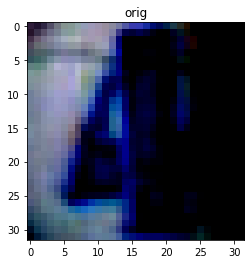

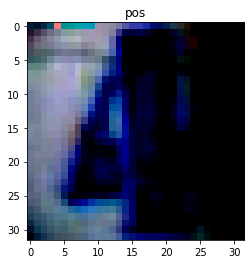

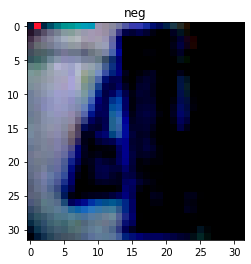

In [ ]:
    for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
            visualize_sample(data, dataset, name)

### Train and Test the Neural Network using FF Algorithm and Report Errors (rates)

In [ ]:
    # net.train(x_pos, x_neg)
    net.train(x_pos, x_neg, logger_gpu_compute, logger_e2e, reference_time)
    print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

    x_te, y_te = next(iter(test_loader))
    x_te, y_te = x_te.cuda(), y_te.cuda()

    print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

training layer 0 ...


  0%|          | 0/1000 [00:00<?, ?it/s]INFO:SVHN_logger_gpu_compute:0,0.0,40.64923453330994
INFO:SVHN_logger_gpu_compute:1,0.0,40.65427231788635
INFO:SVHN_logger_gpu_compute:2,0.0,40.658936977386475
INFO:SVHN_logger_gpu_compute:3,0.0,40.66567611694336
INFO:SVHN_logger_gpu_compute:4,0.0,40.66969418525696
INFO:SVHN_logger_gpu_compute:5,0.0,40.676541328430176
INFO:SVHN_logger_gpu_compute:6,0.0,40.68043780326843
INFO:SVHN_logger_gpu_compute:7,0.0,40.685633420944214
INFO:SVHN_logger_gpu_compute:8,0.0,40.690322160720825
INFO:SVHN_logger_gpu_compute:9,0.0,40.694716930389404
INFO:SVHN_logger_gpu_compute:10,0.0,40.699551820755005
INFO:SVHN_logger_gpu_compute:11,0.0,40.70369243621826
INFO:SVHN_logger_gpu_compute:12,0.0,40.70807337760925
INFO:SVHN_logger_gpu_compute:13,0.0,40.7127583026886
INFO:SVHN_logger_gpu_compute:14,0.0,40.731365442276
INFO:SVHN_logger_gpu_compute:15,0.0,40.81917190551758
  2%|▏         | 16/1000 [00:00<00:11, 87.24it/s]INFO:SVHN_logger_gpu_compute:16,0.0,40.90522861480713


training layer 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]INFO:SVHN_logger_gpu_compute:0,0.0,120.44135689735413
INFO:SVHN_logger_gpu_compute:1,0.0,120.4455053806305
INFO:SVHN_logger_gpu_compute:2,0.0,120.45148134231567
INFO:SVHN_logger_gpu_compute:3,0.0,120.45561194419861
INFO:SVHN_logger_gpu_compute:4,0.0,120.46151041984558
INFO:SVHN_logger_gpu_compute:5,0.0,120.46823620796204
INFO:SVHN_logger_gpu_compute:6,0.0,120.4723858833313
INFO:SVHN_logger_gpu_compute:7,0.0,120.47693181037903
INFO:SVHN_logger_gpu_compute:8,0.0,120.48191523551941
INFO:SVHN_logger_gpu_compute:9,0.0,120.4865608215332
INFO:SVHN_logger_gpu_compute:10,0.0,120.49136662483215
INFO:SVHN_logger_gpu_compute:11,0.0,120.49625420570374
INFO:SVHN_logger_gpu_compute:12,0.0,120.50130772590637
INFO:SVHN_logger_gpu_compute:13,0.0,120.50606870651245
INFO:SVHN_logger_gpu_compute:14,0.0,120.51355075836182
INFO:SVHN_logger_gpu_compute:15,0.0,120.5186493396759
INFO:SVHN_logger_gpu_compute:16,0.0,120.52379059791565
INFO:SVHN_logger_gpu_compute:17,0.0,120

train error: 0.3906499743461609
test error: 0.4147000312805176


In [ ]:
!zip -r /content/MNIST_logs.zip /content/MNIST/
!zip -r /content/FashionMNIST_logs.zip /content/FashionMNIST/
!zip -r /content/CIFAR10_logs.zip /content/CIFAR10/
!zip -r /content/CIFAR100_logs.zip /content/CIFAR100/
!zip -r /content/SVHN_logs.zip /content/SVHN/

  adding: content/MNIST/ (stored 0%)
  adding: content/MNIST/gpu_compute.csv (deflated 57%)
  adding: content/MNIST/e2e.csv (deflated 14%)
  adding: content/FashionMNIST/ (stored 0%)
  adding: content/FashionMNIST/gpu_compute.csv (deflated 57%)
  adding: content/FashionMNIST/e2e.csv (deflated 13%)
  adding: content/CIFAR10/ (stored 0%)
  adding: content/CIFAR10/gpu_compute.csv (deflated 57%)
  adding: content/CIFAR10/e2e.csv (deflated 13%)
  adding: content/CIFAR100/ (stored 0%)
  adding: content/CIFAR100/gpu_compute.csv (deflated 57%)
  adding: content/CIFAR100/e2e.csv (deflated 14%)
  adding: content/SVHN/ (stored 0%)
  adding: content/SVHN/gpu_compute.csv (deflated 58%)
  adding: content/SVHN/e2e.csv (deflated 15%)
